# Binary classification - Blobs

We will consider a simple binary classification problem with the goal of distinguishing between 2 blobs. The neural network will receive two inputs - x, y coordinates of a point, and it will have to decide if the point belongs to blob 1 or 2.

The workflow is the following:
1. Generate the data.
2. Setup the model.
3. Setup the training loop.
4. Evaluate the model.

____________________

Code based on the course:

https://youtu.be/V_xro1bcAuA?si=tfb944xCazZhw95Z

This is not a problem from that course.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torch import nn
from tqdm.auto import tqdm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


## 1. Generate the data

(torch.Size([2000, 2]), torch.Size([2000]))

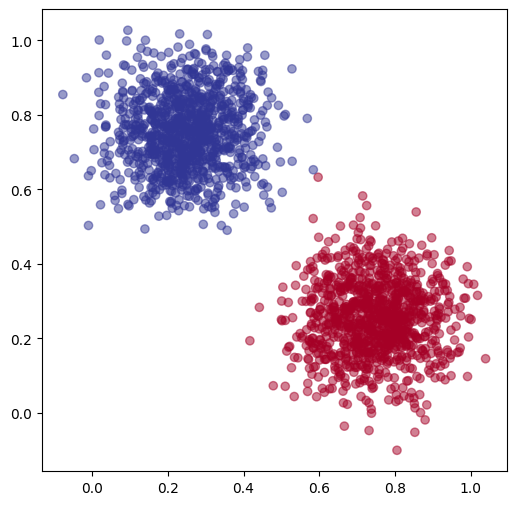

In [11]:
X, y = make_blobs(n_samples = 2000,
                  n_features = 2,
                  centers = np.array([[0.75,0.25],[0.25,0.75]]),
                  cluster_std = 0.1)

plt.figure(figsize = (6,6))
plt.scatter(X[:,0], X[:,1], c = y, cmap = "RdYlBu", alpha = 0.5);

# Turn data to torch.Tensor
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

X.shape, y.shape

Our goal will be to train neural network to distinguish between the red and blue blob.

### Split data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Shapes of data:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} | y_test: {y_test.shape}")

Shapes of data:
X_train: torch.Size([1600, 2]) | y_train: torch.Size([1600])
X_test: torch.Size([400, 2]) | y_test: torch.Size([400])


## 2. Setup the model

We will setup a simple stack of linear layers with one hidden layer of 5 perceptrons.

* input shape: 2, since we enter 2 coordinates.
* output shape: 1, since we want to extract one information from the network.

In [13]:
model = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

In [14]:
# Pick the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD( params = model.parameters(), lr = 0.1 )

## 3. Setup the training loop

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

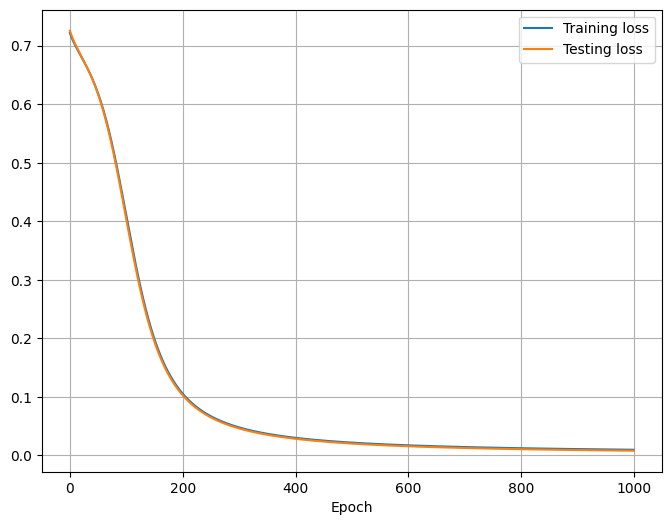

In [15]:
# Set number of epochs
EPOCHS = 1000

# Setup lists to keep track of the loss
train_loss_list, test_loss_list = [], []

for epoch in tqdm(range(EPOCHS)):
  ### Training
  model.train()

  # Forward pass
  y_logits = model(X_train).squeeze()

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  train_loss_list.append(loss.item())

  # Zero the gradients
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    # Forward pass
    y_test_logits = model(X_test).squeeze()

    # Calculate the loss
    test_loss = loss_fn(y_test_logits, y_test)
    test_loss_list.append(test_loss.item())

# Plot the loss curves
plt.figure(figsize=(8,6))
plt.plot(range(EPOCHS), train_loss_list, label = "Training loss")
plt.plot(range(EPOCHS), test_loss_list, label = "Testing loss")
plt.legend()
plt.grid()
plt.xlabel("Epoch")

## 4. Evaluate the model.

First, we will draw 8 random test samples and see if the predictions are correct.

In [16]:
random_indexes = random.sample(range(len(y_test)), k=8)

model.eval()
for idx in random_indexes:
  # Get true label
  if y_test[idx] == 0:
    true_label = "red"
  else:
    true_label = "blue"

  # Get model prediction
  test_logit = model( X_test[idx] )
  test_pred = torch.round( torch.sigmoid(test_logit) )
  if test_pred == 0:
    model_prediction = "red"
  else:
    model_prediction = "blue"

  if true_label == model_prediction:
    evaluation = "CORRECT"
  else:
    evaluation = "WRONG"

  print("--------------------")
  print(f"Point: {X_test[idx][0].item():.2f}, {X_test[idx][1].item():.2f}")
  print(f"True label: {true_label} | Prediction: {model_prediction}")
  print(f"Evaluation: {evaluation}")

--------------------
Point: 0.68, 0.26
True label: red | Prediction: red
Evaluation: CORRECT
--------------------
Point: 0.67, 0.12
True label: red | Prediction: red
Evaluation: CORRECT
--------------------
Point: 0.28, 0.78
True label: blue | Prediction: blue
Evaluation: CORRECT
--------------------
Point: 0.16, 0.69
True label: blue | Prediction: blue
Evaluation: CORRECT
--------------------
Point: 0.35, 0.66
True label: blue | Prediction: blue
Evaluation: CORRECT
--------------------
Point: 0.20, 0.64
True label: blue | Prediction: blue
Evaluation: CORRECT
--------------------
Point: 0.60, 0.18
True label: red | Prediction: red
Evaluation: CORRECT
--------------------
Point: 0.21, 0.66
True label: blue | Prediction: blue
Evaluation: CORRECT


Let's plot the decision boundary using the `plot_decision_boundary()` from https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py.

First, we need to import that function from GitHub.

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
# (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("`helper_functions.py` aleredy exists, skipping download")
else:
  print("Downloading `helper_functions.py`")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary

`helper_functions.py` aleredy exists, skipping download


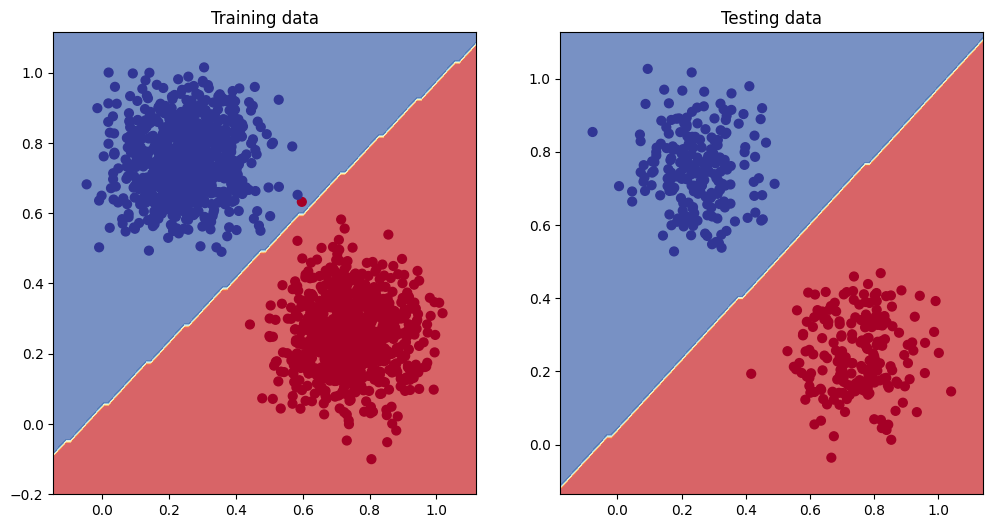

In [18]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training data")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Testing data")
plot_decision_boundary(model, X_test, y_test)